# Here, we decide to learn tensorflow from a simple example directly!

## General writing flow
1. import required libraries
2. load data and do some data pre-processing
3. split your data into training and validation set
4. build the network
5. train the model and record/monitoring the performance

## 1. Import required libries and set some parameters 

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import os

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
'''設定參數'''
batch_size =32
epochs = 100
lr = 0.001
train_ratio= 0.9

'''或者你可以將以上參數換成下面的呈現方式'''
# import argparse
# parser = argparse.ArgumentParser()
# parser.add_argument('--batch_size', default = 32, type = int)
# parser.add_argument('--epochs', default = 100, type = int)
# parser.add_argument('--lr', default = 0.001, type = float)
# parser.add_argument('--train_ratio', default = 0.9, type = float)
# FLAGS = parser.parse_args([]) # if not jupyter notebook, remove []

'或者你可以將以上參數換成下面的呈現方式'

In [3]:
# You should always set visible devices before importing tensorflow
#os.environ['CUDA_VISIBLE_DEVICES'] = str(FLAGS.gpu_id)
import tensorflow as tf

## 2. Load data and do some pre-processing
We use MNIST HERE (with sklearn 8x8 version rather than use tensorflow 28x28 version)

讓我們先來寫一個one hot encoding function

In [12]:
def one_hot_target(y_, all_kind_target_list=None):
    if  all_kind_target_list==None:
        all_kind_target_list=np.unique(y_)
    all_kind_target_number=len(all_kind_target_list)
    y_one_hot = np.zeros((len(y_), all_kind_target_number))  
    for i ,data_val in enumerate(y_):
        yindex = all_kind_target_list.index(data_val)
        y_one_hot[i, yindex] = 1
    return y_one_hot, all_kind_target_list

# 我們只在這裡修改x,y和所有可能的y值的list(targetlist)!!
## 請嘗試各種資料集做測試!!

In [14]:
from sklearn import datasets
# -----------------------------load data----------------------------------------
#只改這邊
iris = datasets.load_iris()
x_, y_ =iris.data, iris.target
targetlist=range(3) #比如手寫數字辨識就是[0,1,2,3,4,5,6,7,8,9]，iris只有三個類別[0,1,2]
#到這邊你已經改完拉
# -----------------------do data pre-processing--------------------------------- 
#---------one way of normalization--------
# x_ = x_ / x_.max() 


In [ ]:
#---------將資料做One-Hot Encoding--------- 
def one_hot_target(y_, all_kind_target_list=None):
    if  all_kind_target_list==None:
        all_kind_target_list=np.unique(y_)
    all_kind_target_number=len(all_kind_target_list)
    y_one_hot = np.zeros((len(y_), all_kind_target_number))  
    for i ,data_val in enumerate(y_):
        yindex = all_kind_target_list.index(data_val)
        y_one_hot[i, yindex] = 1
    return y_one_hot, all_kind_target_list

y_one_hot,targetlist=one_hot_target(y_, all_kind_target_list=targetlist)

## 3. Split your data into training and validation sets

In [8]:
#----------------------------資料training set, testing set 分割---------------------------------------
x_train, x_test, y_train, y_test = train_test_split(x_, 
                                                    y_one_hot, 
                                                    test_size = 0.05, 
                                                    stratify  = y_)
#資料training set, validation set 分割
x_train, x_valid, y_train, y_valid = train_test_split(x_train, 
                                                      y_train, 
                                                      test_size = 1.0 - train_ratio,
                                                      stratify = y_train.argmax(axis = 1))
#------------------------------------檢查資料---------------------------------------------------------
print("training set data dimension")
print(x_train.shape)
print(y_train.shape)
print("-----------")
print("training set: %i" % len(x_train))
print("validation set: %i" % len(x_valid))
print("testing set: %i" % len(x_test))

training set data dimension
(127, 4)
(127, 3)
-----------
training set: 127
validation set: 15
testing set: 8


## 4. build graph

In [15]:
# ------------------------------------graph-----------------------------------------
tf.reset_default_graph() # clean graph
# Declare the input node
with tf.name_scope('input'):
    x_input = tf.placeholder(shape = (None,x_train.shape[1]), 
                             name = 'x_input',
                             dtype=tf.float32)
    y_out = tf.placeholder(shape = (None, y_train.shape[1]), 
                           name = 'y_label',
                           dtype=tf.float32)

# --------------------Declare the network structure----------------------------

with tf.variable_scope('hidden_layer'):
    x_h1 = tf.layers.dense(inputs= x_input, units= 25, activation=tf.nn.sigmoid)


with tf.variable_scope('output_layer'):
    output = tf.layers.dense(x_h1, len(targetlist))
'''---------------------------------------------------------------------------'''
with tf.name_scope('predict_ans'):
    predict_ans=tf.argmax(tf.nn.softmax(output),1)
with tf.name_scope('cross_entropy'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y_out))
    
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(output),1), tf.argmax(y_out,1))
    compute_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

## 5b. Train the model and collect the performance

100%|██████████| 100/100 [00:00<00:00, 116.36it/s]


--- training done ---
testing accuracy: 0.88


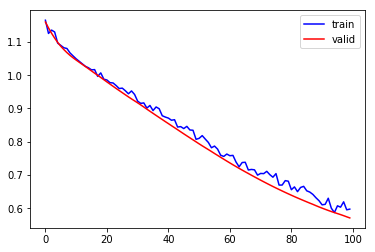

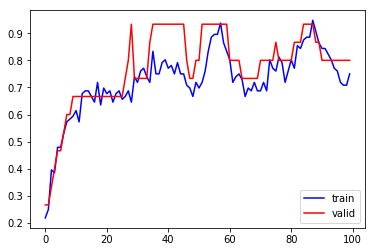

In [16]:
train_loss_list, valid_loss_list = [], []
train_acc_list, valid_acc_list = [], []
#--------------------------------------sess--------------------------------------------
sess = tf.InteractiveSession()
# we have to initalize all variables (e.g. weights/biases) at the begin
sess.run([tf.global_variables_initializer()])

for i in tqdm(range(epochs)):
    # get batch 
    total_batch = int(np.floor(len(x_train) / batch_size)) # just drop out last few samples...

    train_loss_collector, train_acc_collector = [], []
    for j in np.arange(total_batch):
        batch_idx_start = j * batch_size
        batch_idx_stop = (j+1) * batch_size

        x_batch = x_train[batch_idx_start : batch_idx_stop]
        y_batch = y_train[batch_idx_start : batch_idx_stop]

        this_loss, this_acc, _ = sess.run([loss, compute_acc,train_step],
                                feed_dict = {x_input: x_batch,
                                             y_out: y_batch})
        train_loss_collector.append(this_loss)
        train_acc_collector.append(this_acc)

    # do validation at the end of each epoch
    valid_acc, valid_loss = sess.run([compute_acc, loss],
                                     feed_dict = {x_input: x_valid,
                                                  y_out : y_valid})
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    train_loss_list.append(np.mean(train_loss_collector))
    train_acc_list.append(np.mean(train_acc_collector))

    # at the end of each epoch, shuffle the data
    x_train, y_train = shuffle(x_train, y_train)
# At the end of the training, do testing set
test_acc, test_loss = sess.run([compute_acc, loss],
                                feed_dict = {x_input: x_test,
                                             y_out : y_test})
print('--- training done ---')
print('testing accuracy: %.2f' % test_acc)
#--------------------------------------plot---------------------------------------------
plt.plot(np.arange(len(train_loss_list)), train_loss_list, 'b', label = 'train')
plt.plot(np.arange(len(valid_loss_list)), valid_loss_list, 'r', label = 'valid')
plt.legend()
plt.show()

plt.plot(np.arange(len(train_acc_list)), train_acc_list, 'b', label = 'train')
plt.plot(np.arange(len(valid_acc_list)), valid_acc_list, 'r', label = 'valid')
plt.legend(loc = 4)
plt.show()

In [17]:
def predict(x):
    if np.ndim(x)==1:
        x=x.reshape([1,-1])
#     with tf.Session() as sess:
        # we have to initalize all variables (e.g. weights/biases) at the begin
#         sess.run([tf.global_variables_initializer()])
    
    
    return sess.run(predict_ans,feed_dict = {x_input:x})

In [ ]:
import random

In [65]:
i=random.randint(0,len(y_))

print('for the example',i,', prediction is',predict(x_[i]),', and answer is',y_[i])


for the example 127 , prediction is [2] , and answer is 2
